<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/image_segmentation_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像セグメンテーションのタスクを実行

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、opencv_sample.pngをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# opencv(cv2)のverを確認
print(cv2.__version__)

4.10.0


## 画像の読み込みと表示

In [5]:
image_path = INPUT_FILE_PATH + "opencv_sample.png"
np_img = np.fromfile(image_path, np.uint8)
img_gray = cv2.imdecode(np_img, flags=cv2.IMREAD_GRAYSCALE)  # グレースケール
img_color = cv2.imdecode(
    np_img, flags=cv2.IMREAD_COLOR
)  # カラー BGRの3チャネル　RGBでない

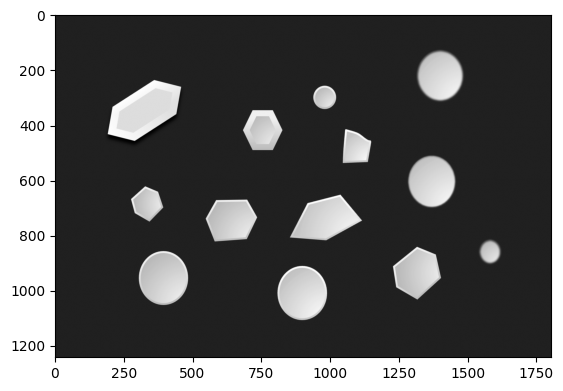

In [6]:
plt.imshow(img_gray, cmap="gray")
plt.show()

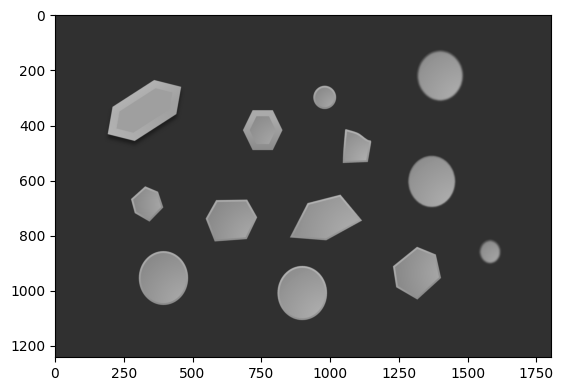

In [7]:
plt.imshow(
    cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
)  # チャネル順をBGRからRGBに変換
plt.show()

In [8]:
# 色空間の変換
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)  # BGRからRGBへの変換
img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV_FULL)  # BGRからHSVへの変換(H:色相　S:彩度　V:明度)

## 画像情報の確認

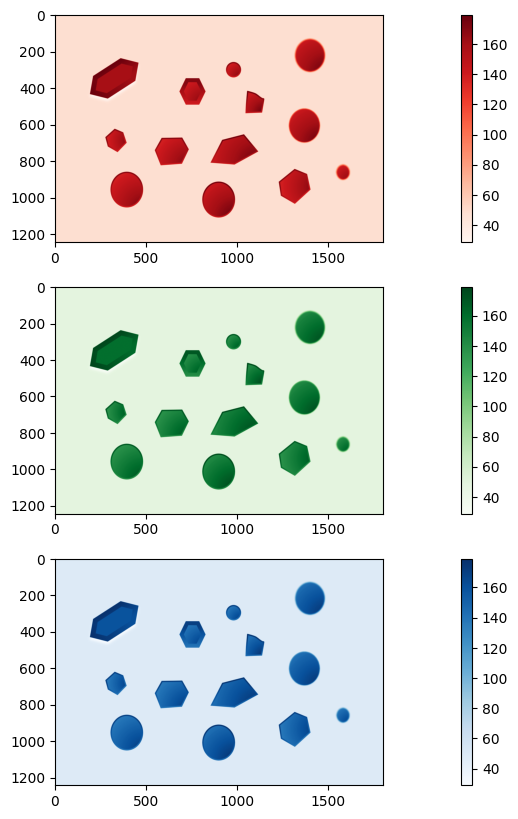

In [9]:
# チャネルごとの画像の表示
plot_img = img_rgb
color_map_list = ["Reds", "Greens", "Blues"]
fig = plt.figure()
for i in range(len(color_map_list)):
    plt.subplot(3, 1, i + 1)
    plt.imshow(plot_img[:, :, i], cmap=color_map_list[i])
    plt.colorbar()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.show()

<ipython-input-10-61f7ed1fdc88>:2: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(img_gray.ravel(), 256, [0, 256])


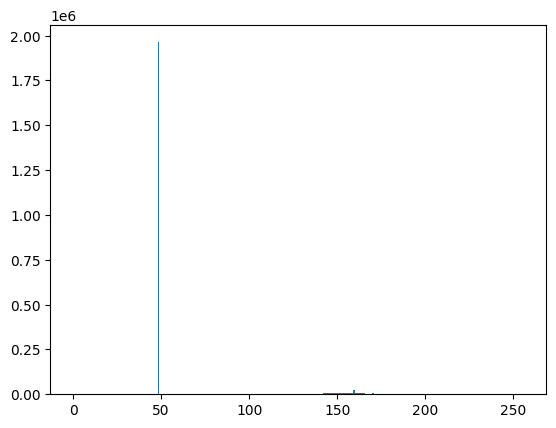

In [10]:
# 画像ヒストグラム確認
plt.hist(img_gray.ravel(), 256, [0, 256])
plt.show()

## 前処理

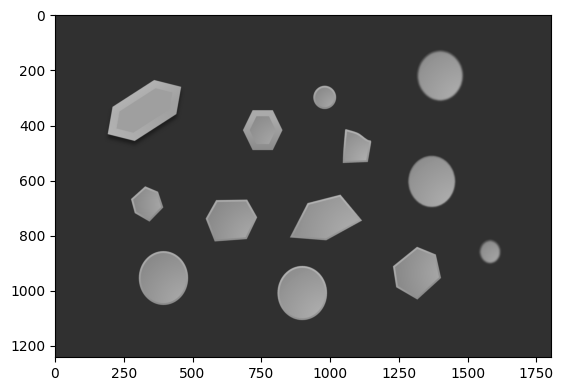

In [11]:
# 前処理前の参考
plt.imshow(
    cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
)  # チャネル順をBGRからRGBに変換する必要がある
plt.show()

### フィルタリング（フィルターをかけることで微小なノイズを除去する）

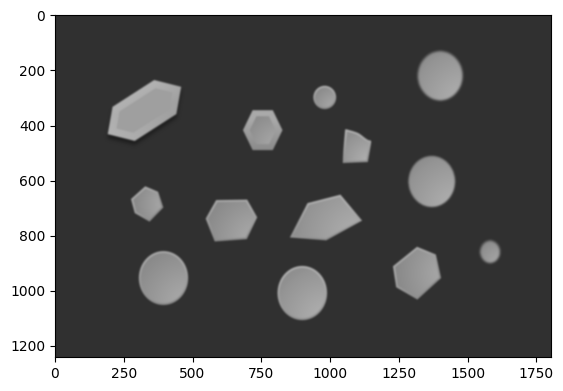

In [12]:
gauss = cv2.GaussianBlur(img_color, (15, 15), 3)  # ガウシアンフィルタ
plt.imshow(
    cv2.cvtColor(gauss, cv2.COLOR_BGR2RGB)
)  # チャネル順をBGRからRGBに変換する必要がある
plt.show()

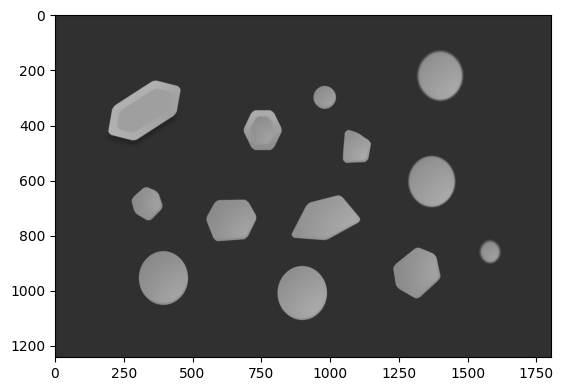

In [13]:
median = cv2.medianBlur(img_color, 25)  # 中央値フィルタ
plt.imshow(
    cv2.cvtColor(median, cv2.COLOR_BGR2RGB)
)  # チャネル順をBGRからRGBに変換する必要がある
plt.show()

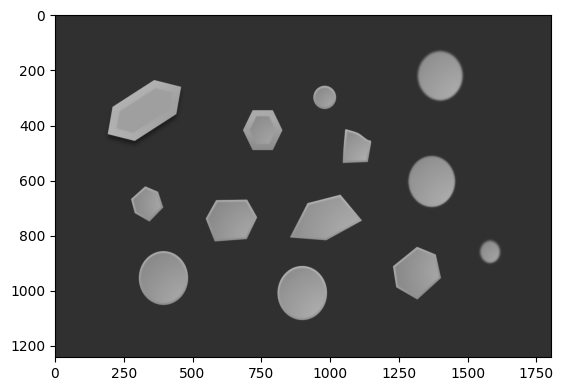

In [14]:
bilate = cv2.bilateralFilter(
    img_color, 9, 75, 75
)  # バイラテラルフィルタ(エッジが残りやすい)
plt.imshow(
    cv2.cvtColor(bilate, cv2.COLOR_BGR2RGB)
)  # チャネル順をBGRからRGBに変換する必要がある
plt.show()

### 階調の変換

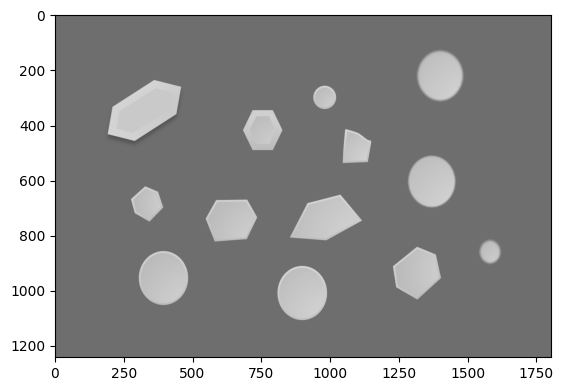

In [15]:
# cv2.LUTを利用し、ピクセルの値を任意の式を適用して値を変換することで、色味を調整する
gamma = 2.0
table = 255 * (np.array(range(256)) / 255) ** (1.0 / gamma)  # ガンマ変換初期値
table = table.astype(np.uint8)

# 変換の実施
gamma_img = cv2.LUT(img_color, table)

plt.imshow(
    cv2.cvtColor(gamma_img, cv2.COLOR_BGR2RGB)
)  # チャネル順をBGRからRGBに変換する必要がある
plt.show()

## 二値化

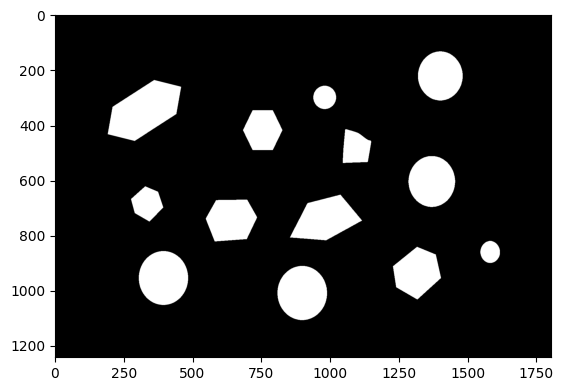

In [16]:
# オーソドックスな二値化
_, img_gray_simple_thresh = cv2.threshold(
    img_gray, thresh=100, maxval=255, type=cv2.THRESH_BINARY
)
plt.imshow(img_gray_simple_thresh, cmap="gray")
plt.show()

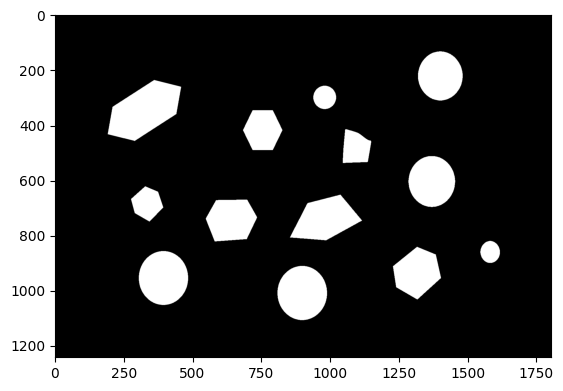

In [17]:
# 大津の二値化法
_, img_gray_otsu_thresh = cv2.threshold(
    img_gray, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
plt.imshow(img_gray_otsu_thresh, cmap="gray")
plt.show()

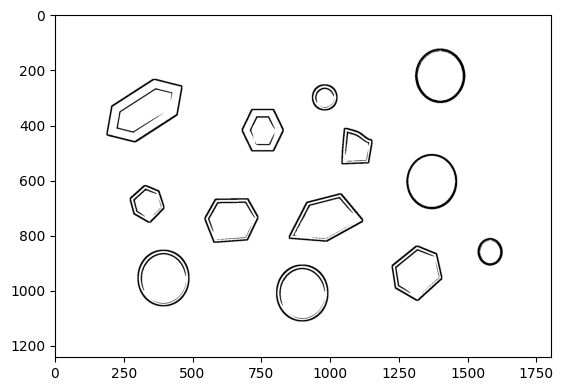

In [18]:
# 適応的二値化：平均
img_gray_adp_mean_thresh = cv2.adaptiveThreshold(
    img_gray,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=11,
    C=2,
)
plt.imshow(img_gray_adp_mean_thresh, cmap="gray")
plt.show()

## 後処理（2値化で抽出した領域へラベル付けを行う）

In [19]:
# ラベリング処理（nlabels:ラベルの数, labels:ラベル結果, stats:バウンディングボックス（開始点の x 座標、y 座標、幅、高さ）とオブジェクトのサイズ, centroids:重心）
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    img_gray_simple_thresh
)

In [20]:
# バウンディングボックスの開始点の x 座標、y 座標、幅、高さおよびオブジェクトのサイズ
stats  # 1行目は背景領域

array([[      0,       0,    1803,    1243, 1985750],
       [   1317,     132,     162,     179,   22668],
       [    191,     236,     267,     222,   36767],
       [    937,     257,      83,      85,    5519],
       [    682,     346,     143,     145,   15715],
       [   1044,     415,     103,     123,    9907],
       [   1282,     513,     170,     185,   24524],
       [    276,     623,     117,     128,    9606],
       [    852,     653,     262,     166,   26639],
       [    547,     671,     186,     152,   22155],
       [   1543,     821,      71,      81,    4446],
       [   1226,     842,     174,     192,   22029],
       [    304,     858,     179,     196,   27562],
       [    807,     912,     180,     197,   27842]], dtype=int32)

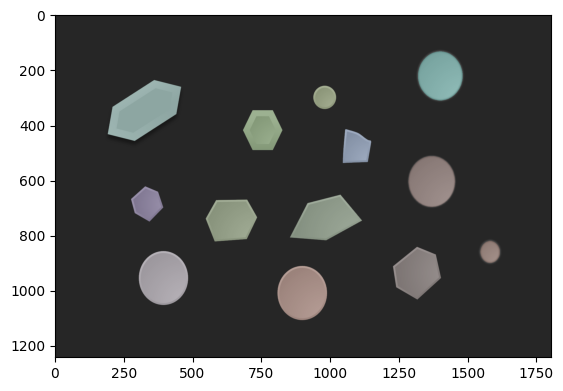

In [21]:
# ラベルを取得した領域の色付き画像を作成
# 背景を除く抽出領域の色を乱数で作成
cols = []
for i in range(1, nlabels):
    cols.append(np.random.choice(range(256), size=3).astype(np.uint8))
# 設定した色でラベルを取得した領域の色付き画像を作成
img = np.zeros(img_color.shape[0:3], dtype=np.uint8)
for j in range(1, nlabels):
    img[labels == j, :] = cols[j - 1]

# 元画像と重ね書きして確認
overwrite_img = cv2.addWeighted(img, 0.2, img_color, 0.8, 0)
plt.imshow(
    cv2.cvtColor(overwrite_img, cv2.COLOR_BGR2RGB)
)  # チャネル順をBGRからRGBに変換する必要がある
plt.show()

## 統計処理

In [22]:
# 平均面積の算出
print(f"平均面積:{stats[1:][:,4].mean():.0f}")
# 個数の算出
print(f"粒子個数:{nlabels-1}")

平均面積:19645
粒子個数:13


## 実行環境のライブラリverを保存

In [23]:
# Pythonのverを確認
!python3 -V

Python 3.11.11


In [24]:
!pip freeze > requirements_image_segmentation_opencv.txt

In [25]:
from google.colab import files

files.download('requirements_image_segmentation_opencv.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>